# Chicago Total Bike Share (Month Aggregated)

**Code used to aggregate by month/day**

In [479]:
# #Group dates
# bike_df.Date = pd.to_datetime(bike_df.Date)
# bike_df['Month'] = bike_df.Date.dt.month
# bike_df['Day'] = bike_df.Date.dt.day

# bike_df = bike_df.dropna(how = 'any')

# bike_df.drop(bike_df[['Date', 'DAILYSnowDepth','DAILYSnowDepth']], axis = 1, inplace = True)

# #Create stats dict for column stats
# f = {'Customer_sum': 'sum', 'Subscriber_sum': 'sum', 'Total_Count sum': 'sum', 'Season': 'mean', 'Holiday': 'mean', 'Duration_mean': 'mean', 'DAILYAverageDryBulbTemp': 'mean', 'DAILYDeptFromNormalAverageTemp': 'mean', 'DAILYAverageRelativeHumidity': 'mean', 'DAILYCoolingDegreeDays': 'mean', 'DAILYSunrise': 'mean', 'DAILYSunset': 'mean', 'DAILYAverageStationPressure': 'mean', 'DAILYAverageWindSpeed': 'mean', 'DAILYSustainedWindSpeed': 'mean', 'DAILYSustainedWindDirection': 'mean'}

# #Aggregate data by day
# bike_df = bike_df.groupby(['Month', 'Day']).agg(f) #Groupby day and apply
# bike_df.to_csv('Chicago_aggregated.csv')

**Import pacakges**

In [480]:
import warnings
warnings.filterwarnings('ignore')

In [481]:
import pandas.io.data as web
import pandas as pd 
import numpy as np 
import matplotlib.pyplot as plt
import datetime as dt
import statsmodels as sm
import seaborn as sns
import pylab
import pprint
import statsmodels.api as sm
import statsmodels.formula.api as smf
import statsmodels.graphics as smgraph
import scipy.stats as stats

from pandas.tools.plotting import scatter_matrix
from sklearn.ensemble import ExtraTreesRegressor
from pandas.tseries.holiday import USFederalHolidayCalendar as calendar
from sklearn.cross_validation import train_test_split, cross_val_score
from sklearn.linear_model import LogisticRegression, LinearRegression
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.metrics import mean_squared_error, f1_score, metrics
from math import sqrt

%matplotlib inline
sns.set_palette("Set2", 10) #Set color scheme
sns.set_style("darkgrid") #Set style for axis
pd.set_option('display.max_rows', 500)

In [482]:
#Import data files
bike_df = pd.read_csv('Chicago_aggregated.csv')
model_df = bike_df.copy() #df copy to model with

In [483]:
model_df.head()

,Month,Day,Customer_sum,Subscriber_sum,Total_Count sum,Season,Season_Name,Holiday,Duration_mean,DAILYSunset,DAILYAverageStationPressure,DAILYSustainedWindSpeed,DAILYSustainedWindDirection,DAILYAverageWindSpeed,DAILYSunrise,DAILYCoolingDegreeDays,DAILYAverageRelativeHumidity,DAILYDeptFromNormalAverageTemp,DAILYAverageDryBulbTemp
0,1,1,2287,6585,8872,1,Winter,1,18.242143,1632.0,29.396667,22.000000,186.666667,13.366667,720.0,0.0,70.333333,-3.066667,21.333333
1,1,2,2748,10685,13433,1,Winter,0,16.233118,1633.0,29.430000,19.000000,250.000000,9.800000,720.0,0.0,71.333333,-4.300000,20.000000
2,1,3,1534,6782,8316,1,Winter,0,13.581355,1634.0,29.333333,23.000000,223.333333,10.700000,720.0,0.0,76.666667,-3.533333,20.666667
3,1,4,935,10190,11125,1,Winter,0,12.048118,1635.0,29.426667,24.333333,286.666667,13.366667,720.0,0.0,72.000000,-1.100000,23.000000
4,1,5,677,11515,12192,1,Winter,0,10.912920,1636.0,29.566667,24.666667,276.666667,12.366667,720.0,0.0,71.333333,-10.666667,13.333333


In [484]:
#Season dummy
season_dummy = pd.get_dummies(model_df.Season_Name)
model_df = pd.concat([model_df, season_dummy], axis = 1)
model_df.drop(['Season_Name'], axis = 1, inplace = True)

#Drop NaN rows
model_df = model_df.dropna(how = 'any')

#Outlier adjust 
# model_df = model_df[model_df['Total_Count sum'] > 13000]
#Chose to keep these points in the model as the are all from the winter season (below)

In [505]:
model_df[model_df['Total_Count sum'] < 13000].head()

,Month,Day,Customer_sum,Subscriber_sum,Total_Count sum,Season,Holiday,Duration_mean,DAILYSunset,DAILYAverageStationPressure,...,DAILYAverageWindSpeed,DAILYSunrise,DAILYCoolingDegreeDays,DAILYAverageRelativeHumidity,DAILYDeptFromNormalAverageTemp,DAILYAverageDryBulbTemp,Fall,Spring,Summer,Winter
0,1,1,2287,6585,8872,1,1,18.242143,1632.0,29.396667,...,13.366667,720.0,0.0,70.333333,-3.066667,21.333333,0.0,0.0,0.0,1.0
2,1,3,1534,6782,8316,1,0,13.581355,1634.0,29.333333,...,10.700000,720.0,0.0,76.666667,-3.533333,20.666667,0.0,0.0,0.0,1.0
3,1,4,935,10190,11125,1,0,12.048118,1635.0,29.426667,...,13.366667,720.0,0.0,72.000000,-1.100000,23.000000,0.0,0.0,0.0,1.0
4,1,5,677,11515,12192,1,0,10.912920,1636.0,29.566667,...,12.366667,720.0,0.0,71.333333,-10.666667,13.333333,0.0,0.0,0.0,1.0
5,1,6,421,10930,11351,1,0,10.762548,1637.0,29.503333,...,13.800000,720.0,0.0,67.333333,-16.900000,7.000000,0.0,0.0,0.0,1.0


# Variable Creation

In [486]:
#Create dependent variable
y = model_df['Total_Count sum']

#Create independent variables
X = model_df.ix[:,'Holiday': 'Winter']

# Data Set Decriptive Stats

In [487]:
model_df.describe()

,Month,Day,Customer_sum,Subscriber_sum,Total_Count sum,Season,Holiday,Duration_mean,DAILYSunset,DAILYAverageStationPressure,...,DAILYAverageWindSpeed,DAILYSunrise,DAILYCoolingDegreeDays,DAILYAverageRelativeHumidity,DAILYDeptFromNormalAverageTemp,DAILYAverageDryBulbTemp,Fall,Spring,Summer,Winter
count,353.000000,353.000000,353.000000,353.000000,353.000000,353.000000,353.000000,353.000000,353.000000,353.000000,...,353.000000,353.000000,353.000000,353.000000,353.000000,353.000000,353.000000,353.000000,353.000000,353.000000
mean,6.526912,15.220963,6027.192635,21764.410765,27791.603399,2.504249,0.033994,15.890705,1777.822946,29.297934,...,9.827644,557.257790,2.454674,66.939566,-0.555571,49.388338,0.249292,0.252125,0.252125,0.246459
std,3.452599,8.520157,4287.794510,8910.248591,12415.061002,1.115800,0.181472,3.380873,109.687400,0.125238,...,2.428847,105.701509,3.681170,7.679163,5.888779,20.270839,0.433217,0.434849,0.434849,0.431561
min,1.000000,1.000000,4.000000,52.000000,56.000000,1.000000,0.000000,9.720214,1620.000000,28.730000,...,3.700000,415.333333,0.000000,40.000000,-23.400000,3.000000,0.000000,0.000000,0.000000,0.000000
25%,4.000000,8.000000,2084.000000,17138.000000,19847.000000,2.000000,0.000000,13.179857,1656.000000,29.216667,...,8.066667,446.250000,0.000000,63.000000,-3.100000,32.750000,0.000000,0.000000,0.000000,0.000000
50%,7.000000,15.000000,5831.000000,22986.000000,28915.000000,3.000000,0.000000,16.179038,1800.666667,29.296667,...,9.575000,542.666667,0.000000,67.000000,0.366667,52.333333,0.000000,0.000000,0.000000,0.000000
75%,10.000000,23.000000,8998.000000,28849.000000,37797.000000,3.000000,0.000000,18.243569,1890.500000,29.377500,...,11.333333,645.000000,5.000000,72.333333,3.400000,69.250000,0.000000,1.000000,1.000000,0.000000
max,12.000000,30.000000,21201.000000,38472.000000,48582.000000,4.000000,1.000000,27.652075,1931.000000,29.680000,...,23.300000,720.000000,14.000000,85.500000,12.800000,79.000000,1.000000,1.000000,1.000000,1.000000


# Dependent Variable Distributions

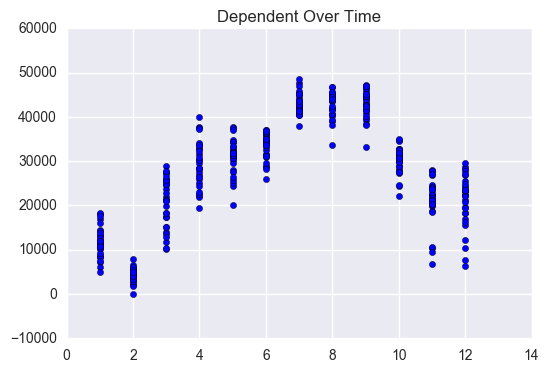

In [488]:
#Count over time
plt.scatter(model_df.Month, model_df['Total_Count sum'])
plt.title('Dependent Over Time')

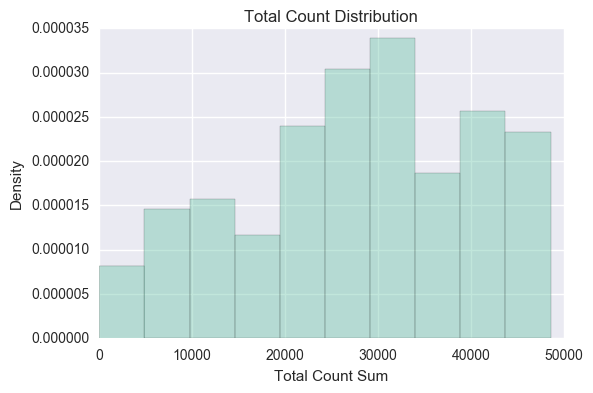

In [489]:
#Dependent distributions
ax = sns.distplot(model_df['Total_Count sum'], kde = False, rug = False, norm_hist = True)
plt.title('Total Count Distribution')
plt.xlabel('Total Count Sum')
ax.set_ylabel('Density')
plt.show()

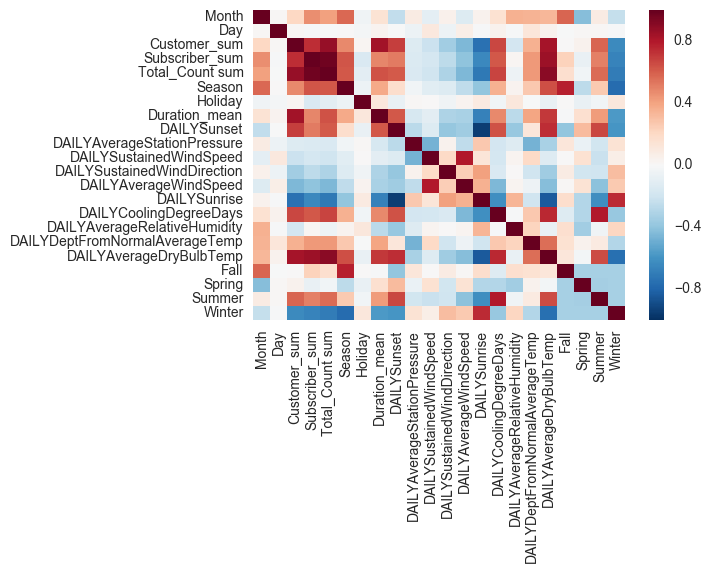

In [490]:
#Correlation Heatmap
corr = model_df.corr()
sns.heatmap(corr)

In [491]:
#Correlation Values List
corr = pd.DataFrame(model_df.corr())
corr.dropna(how='any')

#Dropped (Based on correlation and heatmap > .90): 
# DAILYMaximumDryBulbTemp DAILYMinimumDryBulbTemp (Kept average)
# DAILYAverageSeaLevelPressure (Lower corr to dependent since redundant)
# DAILYPeakWindSpeed PeakWindDirection (Kept Average)
# DAILYAverageDewPointTemp DAILYAverageWetBulbTemp (Lower corr to dependent since redundant)

,Month,Day,Customer_sum,Subscriber_sum,Total_Count sum,Season,Holiday,Duration_mean,DAILYSunset,DAILYAverageStationPressure,...,DAILYAverageWindSpeed,DAILYSunrise,DAILYCoolingDegreeDays,DAILYAverageRelativeHumidity,DAILYDeptFromNormalAverageTemp,DAILYAverageDryBulbTemp,Fall,Spring,Summer,Winter
Month,1.000000,0.012255,0.210513,0.466006,0.407156,0.573880,-0.046806,0.142740,-0.242599,0.082269,...,-0.138087,0.040277,0.153378,0.357777,0.348517,0.328887,0.580502,-0.425552,0.081564,-0.236121
Day,0.012255,1.000000,0.014738,-0.013404,-0.004530,0.005280,-0.021408,0.033762,-0.000644,-0.059644,...,0.067657,-0.008662,0.041609,-0.011635,0.121430,0.043309,-0.003421,0.007924,0.007924,-0.012535
Customer_sum,0.210513,0.014738,1.000000,0.737542,0.874702,0.476770,0.021730,0.840771,0.693600,-0.138510,...,-0.450562,-0.744141,0.670780,-0.186118,0.357965,0.834873,0.005685,0.046299,0.580039,-0.636817
Subscriber_sum,0.466006,-0.013404,0.737542,1.000000,0.972422,0.632106,-0.152917,0.484404,0.517234,-0.146817,...,-0.405838,-0.640727,0.618672,0.020138,0.430974,0.852526,0.229476,-0.073701,0.504905,-0.664846
Total_Count sum,0.407156,-0.004530,0.874702,0.972422,1.000000,0.618323,-0.102244,0.638033,0.610766,-0.153207,...,-0.446880,-0.716852,0.675687,-0.049827,0.432939,0.900195,0.166657,-0.036904,0.562697,-0.697096
Season,0.573880,0.005280,0.476770,0.632106,0.618323,1.000000,-0.056836,0.380551,0.177600,-0.038843,...,-0.251186,-0.395103,0.357802,0.031777,0.269227,0.640747,0.773583,-0.262765,0.258337,-0.772090
Holiday,-0.046806,-0.021408,0.021730,-0.152917,-0.102244,-0.056836,1.000000,0.113109,-0.076648,0.012473,...,0.033043,0.091626,-0.034898,0.111224,-0.000841,-0.073555,0.000307,-0.072919,-0.036918,0.110366
Duration_mean,0.142740,0.033762,0.840771,0.484404,0.638033,0.380551,0.113109,1.000000,0.617540,-0.171414,...,-0.327271,-0.678998,0.482067,-0.266935,0.394530,0.706471,-0.012176,0.156441,0.428212,-0.576886
DAILYSunset,-0.242599,-0.000644,0.693600,0.517234,0.610766,0.177600,-0.076648,0.617540,1.000000,-0.270923,...,-0.356123,-0.952927,0.639153,-0.379649,0.123204,0.739082,-0.398206,0.314031,0.665908,-0.587671
DAILYAverageStationPressure,0.082269,-0.059644,-0.138510,-0.146817,-0.153207,-0.038843,0.012473,-0.171414,-0.270923,1.000000,...,-0.255180,0.266278,-0.184972,-0.131539,-0.471717,-0.321623,0.119434,-0.068832,-0.193898,0.144839


# Categorical Boxplots

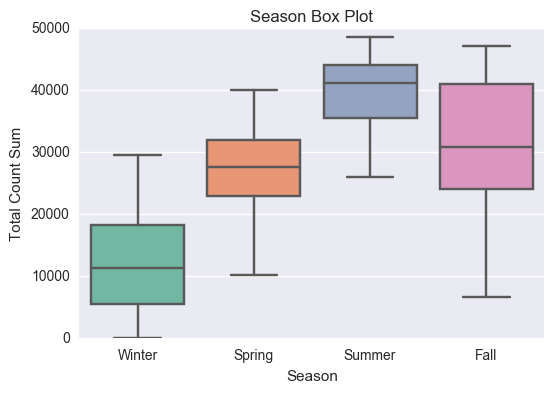

In [492]:
#Season df for labels
seasons_df = model_df[['Total_Count sum', 'Season']]

#Seasons Boxplots
ax = sns.boxplot(y, groupby = bike_df.Season_Name)
plt.title('Season Box Plot')
ax.set_ylabel('Total Count Sum')
plt.xlabel('Season')
plt.show()

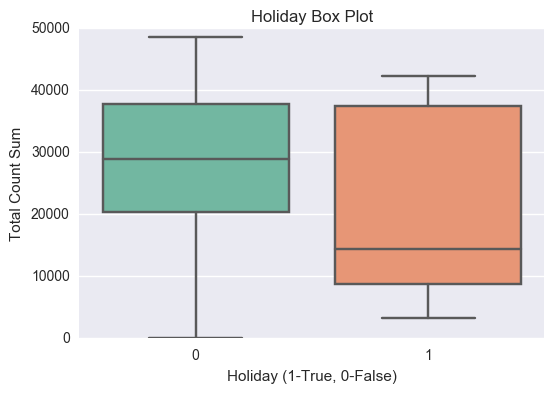

In [493]:
#Holiday Boxplots
ax = sns.boxplot(y, groupby = model_df.Holiday)
plt.title('Holiday Box Plot')
ax.set_ylabel('Total Count Sum')
plt.xlabel('Holiday (1-True, 0-False)')
plt.show()

# Feature Importance

In [495]:
# fit an Extra Trees model to the data (fits n randomized decision trees on subsets of the data)
#uses averaging
model = ExtraTreesRegressor()
model.fit(X, y)
# display the relative importance of each attribute
print(model.feature_importances_)

[ 0.00323365  0.01744522  0.0717598   0.00742914  0.00858959  0.00685099
  0.01141625  0.10079094  0.1476828   0.0089909   0.0087901   0.37009381
  0.00151253  0.02846058  0.00149958  0.20545412]


[0.0038908703564306439, 0.018234603892549769, 0.060039851820798386, 0.011037954913144644, 0.0076448266685834208, 0.0085712401985714552, 0.01577586653225977, 0.23026706608161046, 0.023913810274242744, 0.0091568697440582887, 0.010110965625536239, 0.41710187646046065, 0.0026325032127489617, 0.054679550017556408, 0.00086075228460144679, 0.12608139191684672]


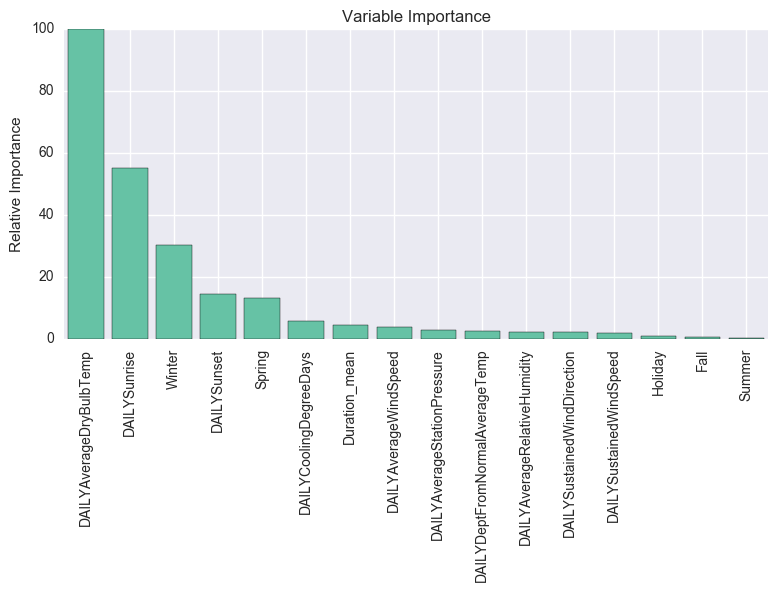

In [496]:
#Fit an Extra Trees model to the data (fits n randomized decision trees on subsets of the data)
#uses averaging
model = ExtraTreesRegressor()
model.fit(X, y)

# Plot feature importance
feature_importance = model.feature_importances_
# normalize importances relative to max importance
print(list(feature_importance))
feature_importance = 100.0 * (feature_importance / feature_importance.max())
# feature_importance = feature_importance[0:50]
sorted_idx = np.argsort(feature_importance)[::-1]
pos = np.arange(sorted_idx.shape[0]) + .5
plt.figure(figsize=(20,4))
plt.subplot(1, 2, 2)
plt.bar(pos, feature_importance[sorted_idx], align='center')
plt.xticks(pos, X.columns[sorted_idx], rotation='vertical')
plt.ylabel('Relative Importance')
plt.title('Variable Importance')

plt.show()

In [497]:
#Final model variables to drop (Based on feature selection)
X.drop(['DAILYAverageWindSpeed', 'DAILYAverageRelativeHumidity', 'DAILYSustainedWindSpeed', 'DAILYSustainedWindDirection', 'DAILYAverageStationPressure', 'DAILYDeptFromNormalAverageTemp', 'DAILYSunset'], axis = 1, inplace = True)

# Training and Test Sets

In [498]:
#Training/Test set from sklearn
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 7777)
print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)

(282, 9)
(282,)
(71, 9)
(71,)


# Linear Regression Model

In [499]:
#Linear regression model
lm = smf.OLS(y_train.astype(float), X_train.astype(float))
results = lm.fit()
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:        Total_Count sum   R-squared:                       0.815
Model:                            OLS   Adj. R-squared:                  0.810
Method:                 Least Squares   F-statistic:                     150.8
Date:                Sun, 04 Jun 2017   Prob (F-statistic):           1.59e-95
Time:                        17:32:57   Log-Likelihood:                -2823.3
No. Observations:                 282   AIC:                             5665.
Df Residuals:                     273   BIC:                             5697.
Df Model:                           8                                         
Covariance Type:            nonrobust                                         
===========================================================================================
                              coef    std err          t      P>|t|      [95.0% Conf. Int.]
-------------------------------------------------------------------------------------------
Holiday                 -3834.3103   2024.737     -1.894      0.059     -7820.393   151.773
Duration_mean             147.8150    145.586      1.015      0.311      -138.798   434.428
DAILYSunrise               25.8260      8.744      2.953      0.003         8.611    43.041
DAILYCoolingDegreeDays     85.0918    191.808      0.444      0.658      -292.518   462.702
DAILYAverageDryBulbTemp   580.7878     49.483     11.737      0.000       483.372   678.204
Fall                    -1.734e+04   7065.873     -2.454      0.015     -3.13e+04 -3431.724
Spring                  -1.649e+04   6273.779     -2.629      0.009     -2.88e+04 -4142.259
Summer                  -1.675e+04   6458.859     -2.594      0.010     -2.95e+04 -4036.601
Winter                   -2.01e+04   6978.218     -2.880      0.004     -3.38e+04 -6362.438
==============================================================================
Omnibus:                        5.152   Durbin-Watson:                   1.941
Prob(Omnibus):                  0.076   Jarque-Bera (JB):                4.944
Skew:                          -0.320   Prob(JB):                       0.0844
Kurtosis:                       3.106   Cond. No.                     2.32e+04
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 2.32e+04. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

# Residual Analysis

In [500]:
#Calculate residuals
train_preds = results.fittedvalues
res = y_train - predicted

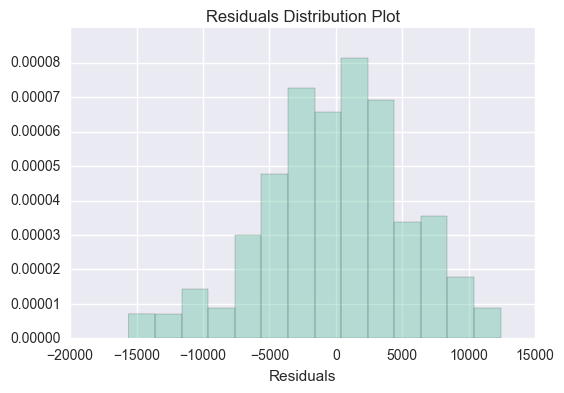

In [501]:
#Residual distribution
ax = sns.distplot(res, kde = False, rug = False, norm_hist = True)
plt.title('Residuals Distribution Plot')
plt.xlabel('Residuals')
plt.show()

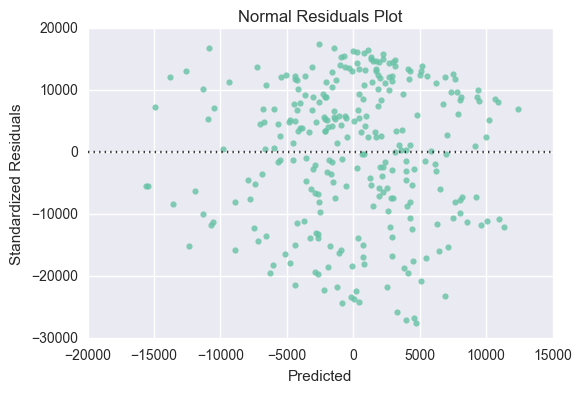

In [502]:
#Normal Residuals Plot
ax = sns.residplot(res, predicted)
plt.title('Normal Residuals Plot')
plt.xlabel('Predicted')
ax.set_ylabel('Standardized Residuals')
plt.show()

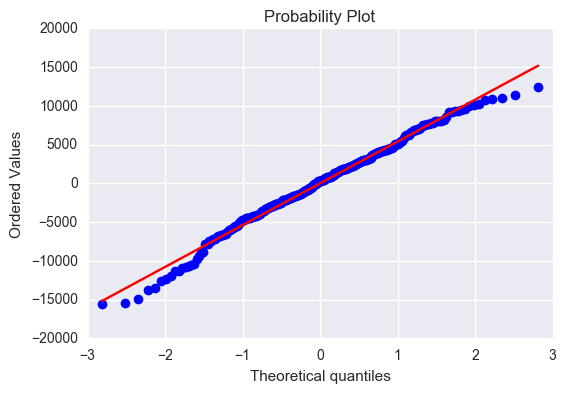

In [503]:
#Probability Plot
measurements = np.random.normal(loc = 20, scale = 5, size=100)   
stats.probplot(res, dist="norm", plot=pylab)
pylab.show()

# Predictions

Train Root Mean Square Error: 5392.023051084919
Test Root Mean Square Error: 4659.812556599494


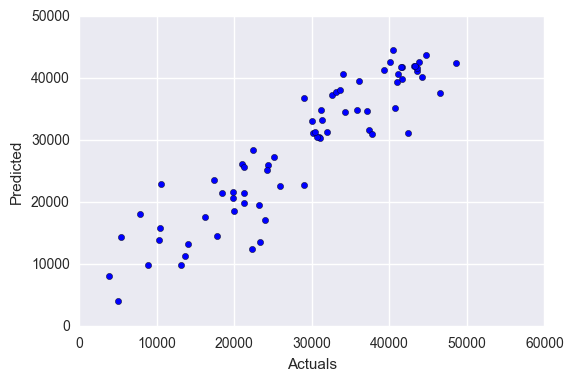

In [504]:
#Prediction on test set/plot predicted vs. actuals
test_preds = results.predict(X_test.astype(float))
plt.scatter(y_test, preds)
plt.xlabel('Actuals')
plt.ylabel('Predicted')
train_rmse = sqrt(mean_squared_error(y_train, train_preds))
test_rmse = sqrt(mean_squared_error(y_test, test_preds)) #RMSE
print('Train Root Mean Square Error: ' + str(train_rmse))
print('Test Root Mean Square Error: ' + str(test_rmse))